<a href="https://colab.research.google.com/github/Syed-Osama-Hussain/Imagined-Speech-Prediction-from-EEG/blob/master/long_words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.io
import os
import keras as ks
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, LSTM, Dropout, Input, Reshape, GRU
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers.merge import concatenate
from keras.models import Model
import keras.backend as K

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls "drive/My Drive/dataset/Long_words/"

Read_me.txt			      sub_6_ch64_l_eog_removed_256Hz.mat
sub_11b_ch64_l_eog_removed_256Hz.mat  sub_7_ch64_l_eog_removed_256Hz.mat
sub_2b_ch64_l_eog_removed_256Hz.mat   sub_9c_ch64_l_eog_removed_256Hz.mat


In [ ]:

mat = scipy.io.loadmat("drive/My Drive/dataset/Long_words/sub_2b_ch64_l_eog_removed_256Hz")
end_trial = mat['eeg_data_wrt_task_rep_no_eog_256Hz_end_trial']
last_beep = mat['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']

In [ ]:
print(end_trial[0][0])

[[  2.0756692    3.3451948    1.2805819  ...   1.03499391  -1.8243698
   -1.01871216]
 [ -3.82600849 -11.7789427  -19.90806902 ...  12.53093915   8.48127123
   11.22360224]
 [ -3.00310901  -5.53589825 -10.7160167  ...   8.79775373   5.17229481
    8.20442485]
 ...
 [ -3.28631204 -12.27128688 -21.85336011 ...   7.17226805   4.4037043
    6.18084104]
 [ -1.91263385  -4.37623631  -7.82609212 ...   1.17744386  -3.16380532
    0.43488985]
 [  2.51450495   6.26755729   2.75070428 ...   1.19598115  -4.54512732
   -1.76451922]]


In [ ]:
print(end_trial[1][0])

[[ -1.27735546  -3.82002997  -2.88641743 ...   1.9763067    2.05661518
    1.3593881 ]
 [ -4.90701477  -8.48444293  -5.82129236 ...  -2.30271976  -0.36951821
    1.3378214 ]
 [ -5.40068243  -9.89625475  -7.20670153 ...  -1.60120045   0.36174521
    4.19075407]
 ...
 [ -5.3620891   -9.69451373  -6.31911269 ...  -3.00807071   0.27529782
    2.78197364]
 [ -6.75004416 -11.84629843  -7.65657429 ...  -0.45278445   0.70701181
    1.51307907]
 [ -6.31367576  -8.92761731  -4.09098874 ...   7.03288896   4.97767805
    3.63721799]]


# Cooperate in resting state

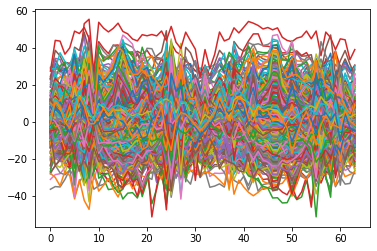

In [ ]:
plt.plot(end_trial[0][0]);

# Cooperate during speech imagery state

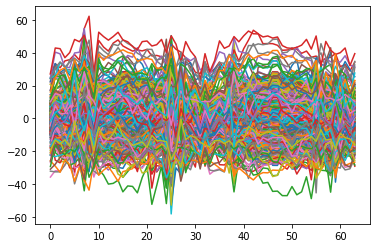

In [ ]:
plt.plot(last_beep[0][0]);

# Independent during resting state

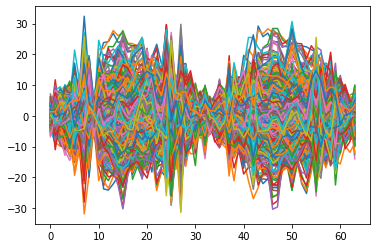

In [ ]:
plt.plot(end_trial[1][0]);

# Independent during speech imagery state

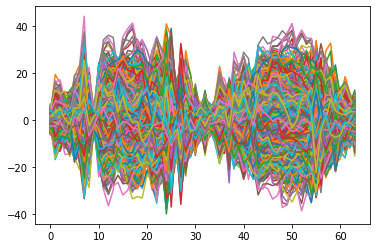

In [ ]:
plt.plot(last_beep[1][0]);

#Covariance Matrix Calculation

In [4]:
def covariance(matrix):
  # res_mat = np.matmul(matrix,matrix.transpose())
  res_mat = (np.cov(matrix,bias=True))
  return res_mat

#Load Matrices:
Here we load matrices for both classes from all files in the directory.

In [5]:
def loadMatrices(dir):
  matrices_c1 = []
  matrices_c2 = []
  for root,sub,files in os.walk(dir):
    for f in sorted(files):
      if f == "Read_me.txt":
        continue
      mat_file  =  scipy.io.loadmat(os.path.join(root, f))
      end_trial = mat_file['eeg_data_wrt_task_rep_no_eog_256Hz_end_trial']
      last_beep = mat_file['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
      matrices_c1.extend([covariance(matrix) for matrix in end_trial[0]])
      matrices_c1.extend([covariance(matrix) for matrix in last_beep[0]])
      matrices_c2.extend([covariance(matrix) for matrix in end_trial[1]])
      matrices_c2.extend([covariance(matrix) for matrix in last_beep[1]])
  return np.concatenate((np.array(matrices_c1),np.array(matrices_c2)),axis=0)


#Data Preparation

In [6]:
x_train = loadMatrices("drive/My Drive/dataset/Long_words/")

In [7]:
print(x_train.shape)
print(x_train[0])

(2000, 64, 64)
[[ 6.32974445 10.58417227  9.53571665 ... 10.63370877  4.94803384
   4.58149477]
 [10.58417227 44.25957688 34.44492861 ... 42.38868176 16.16893681
   5.47314711]
 [ 9.53571665 34.44492861 33.68601914 ... 33.35438957 12.31420443
   7.08534143]
 ...
 [10.63370877 42.38868176 33.35438957 ... 42.36029921 17.01018572
   6.37773712]
 [ 4.94803384 16.16893681 12.31420443 ... 17.01018572 11.42730562
   5.05475793]
 [ 4.58149477  5.47314711  7.08534143 ...  6.37773712  5.05475793
  13.39295356]]


In [8]:
x = np.array([1,0])
y = np.array([0,1])
y_train = np.concatenate((np.repeat(x[np.newaxis,:],1000,0),np.repeat(y[np.newaxis,:],1000,0)),axis=0)
print(y_train.shape)

(2000, 2)


In [9]:
print(y_train)

[[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]


#Model Design

In [10]:

model=Sequential()

model.add(Conv1D(filters=64, kernel_size=2, activation="relu" , input_shape=(64,64)))
# model.add(MaxPooling1D(pool_size=6))
model.add(Conv1D(filters=64, kernel_size=2, activation="relu", input_shape=(64,64)))
# model.add(MaxPooling1D(pool_size=6))
model.add(Flatten())
model.add(Dense(128, activation='relu'))

model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 63, 64)            8256      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 62, 64)            8256      
_________________________________________________________________
flatten (Flatten)            (None, 3968)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               508032    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 541,314
Trainable params: 541,314
Non-trainable params: 0
__________________________________________________

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# print(y_train)
# print(x_train)

#Shuffling and Training

In [21]:
x_train, y_train = shuffle(x_train, y_train)

In [22]:
divide_percent=(len(x_train)*0.2)
x_train, y_train = shuffle(x_train, y_train)
x_test=x_train[0:int(divide_percent)]
y_test=y_train[0:int(divide_percent)]
x_train_final = x_train[int(divide_percent):len(x_train)]
y_train_final = y_train[int(divide_percent):len(y_train)]

400.0 2000


In [23]:
print(x_test.shape)
print(x_train_final.shape)
print(y_test.shape)
print(y_train_final.shape)
# print(x_test,y_test)

(400, 64, 64)
(1600, 64, 64)
(400, 2)
(1600, 2)


In [ ]:
model.fit(x_train_final,y_train_final,validation_data=(x_test,y_test),epochs=300,verbose=1)

Epoch 1/300
25/25 [==============================] - 0s 14ms/step - loss: 31.4036 - accuracy: 0.4963 - val_loss: 3.2348 - val_accuracy: 0.5100
Epoch 2/300
25/25 [==============================] - 0s 5ms/step - loss: 1.1421 - accuracy: 0.5163 - val_loss: 0.7336 - val_accuracy: 0.5200
Epoch 3/300
25/25 [==============================] - 0s 5ms/step - loss: 0.7476 - accuracy: 0.4963 - val_loss: 0.7637 - val_accuracy: 0.5000
Epoch 4/300
25/25 [==============================] - 0s 5ms/step - loss: 0.7073 - accuracy: 0.5325 - val_loss: 0.7361 - val_accuracy: 0.5150
Epoch 5/300
25/25 [==============================] - 0s 5ms/step - loss: 0.6956 - accuracy: 0.5325 - val_loss: 0.7586 - val_accuracy: 0.4850
Epoch 6/300
25/25 [==============================] - 0s 5ms/step - loss: 0.6652 - accuracy: 0.5675 - val_loss: 0.7577 - val_accuracy: 0.5250
Epoch 7/300
25/25 [==============================] - 0s 5ms/step - loss: 0.6704 - accuracy: 0.5550 - val_loss: 0.9738 - val_accuracy: 0.4850
Epoch 8/300

#Results

In [ ]:
predictions = model.predict(x_test)

In [ ]:
np.round(predictions)

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.

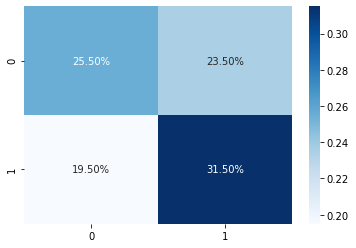

In [ ]:
rounded_labels = np.argmax(y_test, axis=1)
rounded_predictions = np.argmax(predictions, axis=1)
cf = confusion_matrix(rounded_labels,rounded_predictions)  # doctest: +SKIP
sns.heatmap(cf/np.sum(cf), annot=True, fmt='.2%', cmap='Blues')

In [ ]:
print(rounded_predictions)

[1 1 0 0 1 1 1 0 0 0 0 0 1 0 0 1 1 1 1 0 1 1 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0
 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1
 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 0
 1 1 0 0 0 1 0 1 1 0 1 1 1 0 0 1 0 0 0 1 1 0 0 0 1 1 1 1 1 0 1 1 1 0 0 1 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 0 0
 0 0 0 1 1 1 1 0 1 0 0 1 1 1 0]


In [ ]:
print(rounded_labels)

[1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 1 1 1 1 0 1 1
 0 1 0 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 1 0
 1 0 0 1 1 1 0 0 0 1 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 1 1 0 1 0 1 1 1 1 0 0
 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 0 0 1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0
 0 0 0 0 0 1 1 1 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 1 0 0 1
 1 1 0 1 0 1 1 0 0 1 1 1 0 1 0]


# RNN

In [24]:

modelRNN = Sequential()
modelRNN.add(GRU(64,activation="relu",return_sequences=True,input_shape=(64,64)))
modelRNN.add(GRU(64,activation="relu"))
modelRNN.add(Dense(64, activation='relu'))
modelRNN.add(Dense(64, activation='relu'))

# modelRNN.add(LSTM(64,activation="relu"))
# modelRNN.add(Dense(64, activation='relu'))
# modelRNN.add(Flatten())
modelRNN.add(Dense(2, activation='softmax'))
modelRNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 64, 64)            24960     
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 130       
Total params: 58,370
Trainable params: 58,370
Non-trainable params: 0
_________________________________________________________________


In [25]:
modelRNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [26]:
modelRNN.fit(x_train_final,y_train_final,validation_data=(x_test,y_test),epochs=150,verbose=1)

Epoch 1/150
50/50 [==============================] - 5s 96ms/step - loss: 1.6513 - accuracy: 0.5231 - val_loss: 1.0967 - val_accuracy: 0.5025
Epoch 2/150
50/50 [==============================] - 5s 91ms/step - loss: 11.1796 - accuracy: 0.5194 - val_loss: 1.9779 - val_accuracy: 0.4925
Epoch 3/150
50/50 [==============================] - 5s 100ms/step - loss: 6.6951 - accuracy: 0.5256 - val_loss: 2.5568 - val_accuracy: 0.5025
Epoch 4/150
50/50 [==============================] - 5s 90ms/step - loss: 9.7190 - accuracy: 0.5038 - val_loss: 3.1024 - val_accuracy: 0.4825
Epoch 5/150
50/50 [==============================] - 4s 87ms/step - loss: 20.2911 - accuracy: 0.4956 - val_loss: 4.7972 - val_accuracy: 0.4825
Epoch 6/150
50/50 [==============================] - 4s 88ms/step - loss: 15.0018 - accuracy: 0.5319 - val_loss: 2.7931 - val_accuracy: 0.5100
Epoch 7/150
50/50 [==============================] - 4s 87ms/step - loss: 1.2788 - accuracy: 0.5106 - val_loss: 0.7912 - val_accuracy: 0.5200
Ep

In [27]:
predictionsRNN = modelRNN.predict(x_test)
np.round(predictionsRNN)

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

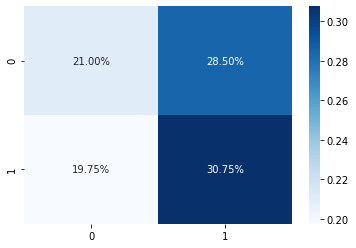

In [28]:
rounded_labels = np.argmax(y_test, axis=1)
rounded_predictionsRNN = np.argmax(predictionsRNN, axis=1)
cfRNN = confusion_matrix(rounded_labels,rounded_predictionsRNN)  # doctest: +SKIP
sns.heatmap(cfRNN/np.sum(cfRNN), annot=True, fmt='.2%', cmap='Blues')

In [ ]:
print(rounded_predictionsRNN)

[1 0 1 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 1 1 0
 1 1 1 1 1 0 0 1 0 1 0 0 1 0 1 1 1 0 1 0 1 1 0 1 0 0 1 1 0 1 1 0 1 1 0 1 1
 0 1 0 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 0 1 1 1 1 1
 0 1 1 1 0 1 0 1 1 0 1 0 1 1 0 0 1 1 1 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1
 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1]


In [ ]:
print(rounded_labels)

[1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 1 1 1 1 0 1 1
 0 1 0 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 1 0
 1 0 0 1 1 1 0 0 0 1 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 1 1 0 1 0 1 1 1 1 0 0
 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 0 0 1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0
 0 0 0 0 0 1 1 1 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 1 0 0 1
 1 1 0 1 0 1 1 0 0 1 1 1 0 1 0]


In [33]:

visible = Input(shape=(64,64))
#CNN
cov1 = Conv1D(filters=64, kernel_size=2, activation="relu")(visible)
cov2 = Conv1D(filters=64, kernel_size=4, activation="relu")(cov1)
newShape = Reshape((60,64), name='newReshape')(cov2)
f1 = Flatten()(newShape)
d1 = Dense(128, activation='relu')(f1)
d2 = Dense(128, activation='relu')(d1)

#RNN
lstm1 = GRU(64,activation="relu",return_sequences=True)(visible)
lstm2 = GRU(64,activation="relu")(lstm1)
d3 = Dense(64, activation='relu')(lstm2)
d4 = Dense(64, activation='relu')(d3)

#Merge
merge = concatenate([d2, d4])

#DAE
encoder1 = Dense(768, activation='relu')(merge)
encoder2 = Dense(96, activation='relu')(encoder1)
decoder1 = Dense(768, activation='relu')(encoder2)
decoder2 = Dense(192, activation='relu')(decoder1)

#FNN
hidden1 = Dense(64, activation='relu')(encoder2)
hidden2 = Dense(64, activation='relu')(hidden1)
output = Dense(2, activation='softmax')(hidden2)
model = Model(inputs=visible, outputs=output)
print(model.summary())

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64)]     0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 63, 64)       8256        input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 60, 64)       16448       conv1d_4[0][0]                   
__________________________________________________________________________________________________
newReshape (Reshape)            (None, 60, 64)       0           conv1d_5[0][0]                   
_______________________________________________________________________________________

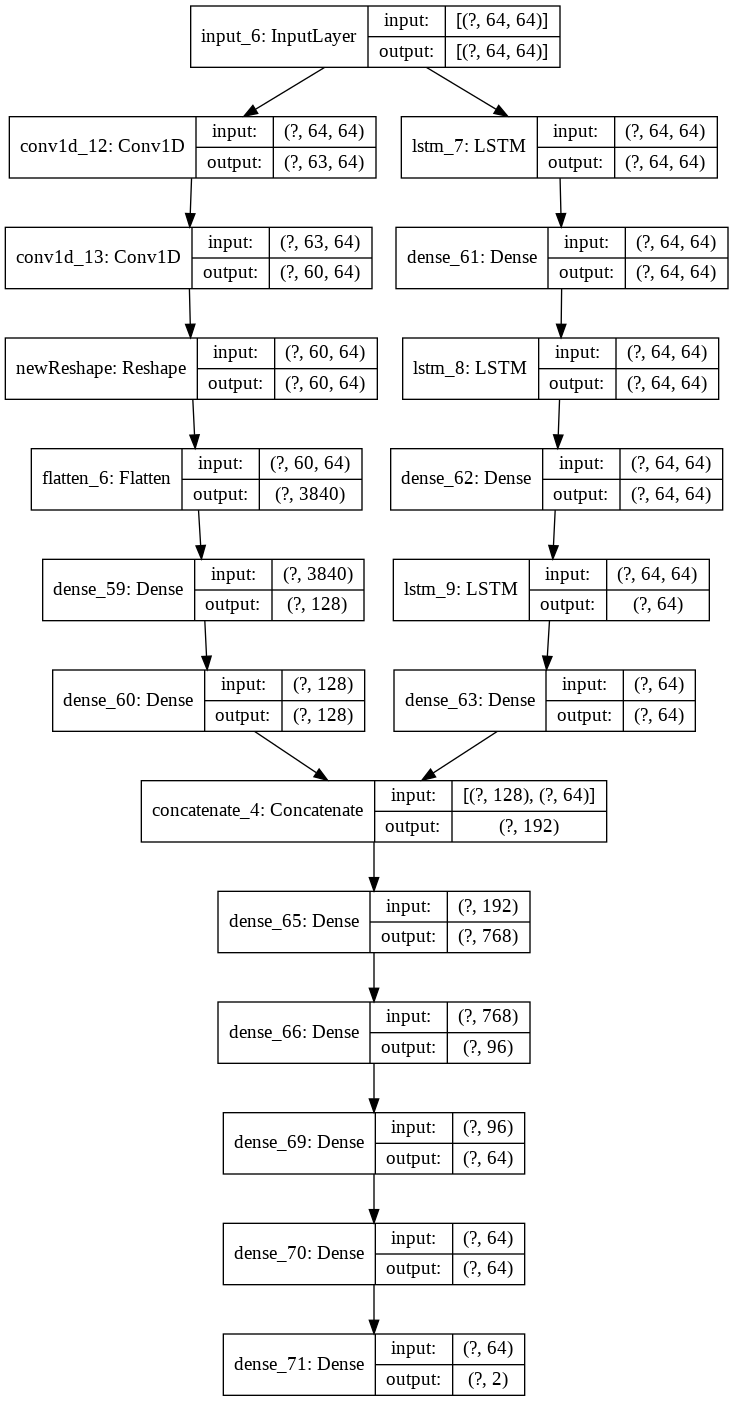

In [60]:
from keras.utils import plot_model
plot_model(model,to_file='demo.png',show_shapes=True)

In [32]:
i = 5


Iteration no  5  for training 


In [34]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Iteration no  0  for training 
Epoch 1/200
50/50 [==============================] - 5s 96ms/step - loss: 3.7762 - accuracy: 0.5069 - val_loss: 0.8396 - val_accuracy: 0.4750
Epoch 2/200
50/50 [==============================] - 4s 88ms/step - loss: 4.8969 - accuracy: 0.5069 - val_loss: 0.8387 - val_accuracy: 0.5250
Epoch 3/200
50/50 [==============================] - 5s 91ms/step - loss: 0.7070 - accuracy: 0.5256 - val_loss: 0.8908 - val_accuracy: 0.4825
Epoch 4/200
50/50 [==============================] - 4s 87ms/step - loss: 4.6849 - accuracy: 0.5100 - val_loss: 0.6946 - val_accuracy: 0.5125
Epoch 5/200
50/50 [==============================] - 5s 90ms/step - loss: 0.7228 - accuracy: 0.5312 - val_loss: 0.7063 - val_accuracy: 0.5275
Epoch 6/200
50/50 [==============================] - 4s 88ms/step - loss: 0.7153 - accuracy: 0.5256 - val_loss: 0.6952 - val_accuracy: 0.5375
Epoch 7/200
50/50 [==============================] - 5s 93ms/step - loss: 1.0211 - accuracy: 0.5256 - val_loss: 0.725

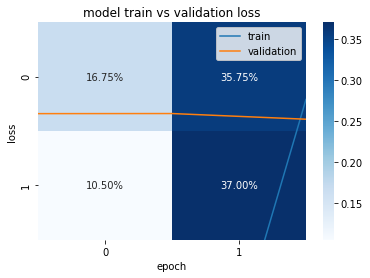

Iteration no  1  for training 
Epoch 1/200
50/50 [==============================] - 4s 89ms/step - loss: 0.6183 - accuracy: 0.6781 - val_loss: 0.5766 - val_accuracy: 0.6350
Epoch 2/200
50/50 [==============================] - 4s 87ms/step - loss: 0.5543 - accuracy: 0.6806 - val_loss: 0.6122 - val_accuracy: 0.6350
Epoch 3/200
50/50 [==============================] - 4s 89ms/step - loss: 0.6556 - accuracy: 0.6400 - val_loss: 0.7155 - val_accuracy: 0.5475
Epoch 4/200
50/50 [==============================] - 4s 85ms/step - loss: 0.8214 - accuracy: 0.5681 - val_loss: 0.7485 - val_accuracy: 0.5400
Epoch 5/200
50/50 [==============================] - 4s 86ms/step - loss: 0.9311 - accuracy: 0.5519 - val_loss: 0.6857 - val_accuracy: 0.5600
Epoch 6/200
50/50 [==============================] - 4s 88ms/step - loss: 2.4458 - accuracy: 0.5800 - val_loss: 0.6938 - val_accuracy: 0.5550
Epoch 7/200
50/50 [==============================] - 4s 87ms/step - loss: 0.7711 - accuracy: 0.5788 - val_loss: 0.646

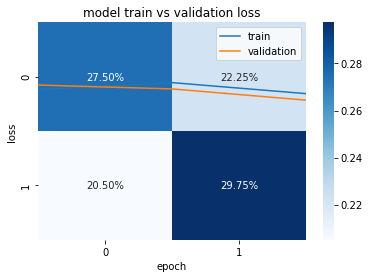

Iteration no  2  for training 
Epoch 1/200
50/50 [==============================] - 5s 94ms/step - loss: 0.6536 - accuracy: 0.6744 - val_loss: 0.5760 - val_accuracy: 0.6325
Epoch 2/200
50/50 [==============================] - 5s 94ms/step - loss: 0.5367 - accuracy: 0.7069 - val_loss: 0.5828 - val_accuracy: 0.6700
Epoch 3/200
50/50 [==============================] - 5s 93ms/step - loss: 0.5391 - accuracy: 0.6938 - val_loss: 0.8707 - val_accuracy: 0.6625
Epoch 4/200
50/50 [==============================] - 5s 92ms/step - loss: 0.6430 - accuracy: 0.6313 - val_loss: 0.6676 - val_accuracy: 0.5775
Epoch 5/200
50/50 [==============================] - 5s 91ms/step - loss: 0.6370 - accuracy: 0.6375 - val_loss: 0.6406 - val_accuracy: 0.5875
Epoch 6/200
50/50 [==============================] - 4s 90ms/step - loss: 0.5488 - accuracy: 0.6750 - val_loss: 0.9574 - val_accuracy: 0.6325
Epoch 7/200
50/50 [==============================] - 5s 96ms/step - loss: 0.5514 - accuracy: 0.6775 - val_loss: 0.788

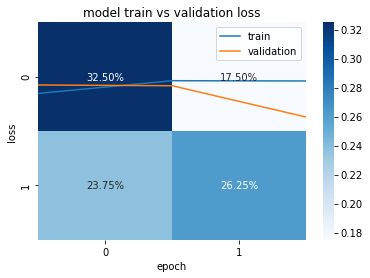

In [35]:
for i in range(3):
  print("Iteration no ",i," for training \n=========\n=========\n=========")
  x_train, y_train = shuffle(x_train, y_train)
  divide_percent=(len(x_train)*0.2)
  x_test=x_train[0:int(divide_percent)]
  y_test=y_train[0:int(divide_percent)]
  x_train_final = x_train[int(divide_percent):len(x_train)]
  y_train_final = y_train[int(divide_percent):len(y_train)]

  history = model.fit(x_train_final,y_train_final,validation_data=(x_test,y_test),epochs=200,verbose=1)
  predictions = model.predict(x_test,verbose=0)
  np.round(predictions)
  rounded_labels = np.argmax(y_test, axis=1)
  rounded_predictions = np.argmax(predictions, axis=1)
  cf = confusion_matrix(rounded_labels,rounded_predictions)  # doctest: +SKIP
  sns.heatmap(cf/np.sum(cf), annot=True, fmt='.2%', cmap='Blues')
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model train vs validation loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.

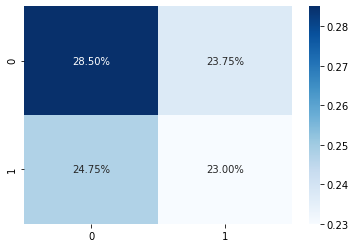

In [19]:
rounded_labels = np.argmax(y_test, axis=1)
rounded_predictions = np.argmax(predictions, axis=1)
cf = confusion_matrix(rounded_labels,rounded_predictions)  # doctest: +SKIP
sns.heatmap(cf/np.sum(cf), annot=True, fmt='.2%', cmap='Blues')

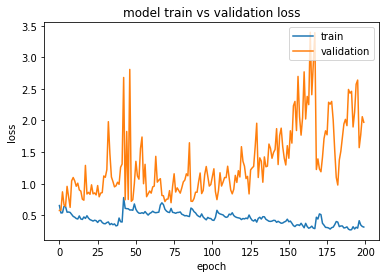

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()